In [16]:
import numpy as np
import csv
from DivisionForP2 import DivisionP2
from collections import Counter
from itertools import combinations
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import matplotlib
import pickle
from DivisionForP2 import Dataset

In [17]:
#用于将数据集（格式为x，y两个numpy数组）拆分为按区域集中的数据样本
#输入为x，y两个数组，等长，且一一对应
#返回值为两个字典，字典的键为area，值为numpy数组，x字典为numpy数组shape是（样本数，AP列表）
#对应的，y字典值为数组，shape为（样本数，3）。3分别是，区域，横坐标，纵坐标
def DivByArea(train_x,train_y):
    x_div_by_area = {} # 是一个字典，键为area，值为样本集的一个子集
    y_div_by_area = {} # 是一个字典，键为area，值为标签集的一个子集
    dic = {}    # dic 是一个字典，键为area，值为该area的样本在输入集中的位置索引列表
    index = []   # 暂时存放位置索引列表
    count = Counter(train_y[:,0]) # counter得到可能的区域和该区域的样本数
    # 虽然本项目中area个数和点数几乎是确定的，但由Counter计算可能更具有普适性
    areas,samples = list(count.keys()),list(count.values())   # 取出区域及其对应的样本数
    for area in areas:
        for num in range(len(train_y)):
            if train_y[num,0] == area:
                index.append(num)
        dic[area] = index
        index = []
    for area in dic.keys():
        x_div_by_area[area] = train_x[dic[area]]
        y_div_by_area[area] = train_y[dic[area]]
    return x_div_by_area,y_div_by_area

In [18]:
#方法用于求得距离比R
#输入为两数字，为RSSI
#输出为距离比R
def DistRatio(Rssi1,Rssi2,eta):
    R = 10**((Rssi2-Rssi1)/(10*eta))
    return R

In [19]:
#方法用于求出阿氏圆
#先前化简后将该圆表达式整合为了一般式
# x^2+y^2+Dx+Ey+F=0
#故而只需要求出D，E，F即可
#根据推导可以直接计算
#输入为AB两点的坐标，和距离比R，该比值由RSSI算出
#输出为D,E,F
def Apollonius(xi,yi,xj,yj,R):
    D = (2*xj*R**2-2*xi)/(1-R**2)
    E = (2*yj*R**2-2*yi)/(1-R**2)
    F = (xi**2+yi**2-xj**2*R**2-yj**2*R**2)/(1-R**2)
    return D,E,F

In [20]:
#方法用于通过两个不同点的样本求得一个阿氏圆
#输入为两个样本的数据和标签，分别标记为（x1,y1）(x2,y2)
#输出为一组（D，E，F），每个用于标记一个圆，共一组，算不得的位置留0
def samples2circle(x1,y1,x2,y2,eta):
    circle = [0]*len(x1)
    for col in range(len(x1)):    # 这两个样本中对于第col个AP
        if x1[col] and x2[col]:    # 如果都有RSSI
            R = DistRatio(x1[col],x2[col],eta)   # 计算距离比
            if R != 1:  # R为1的时候求不出圆
                xi,yi = y1[1],y1[2]        #读取坐标
                xj,yj = y2[1],y2[2]
                D,E,F = Apollonius(xi,yi,xj,yj,R)    #计算DEF
                circle[col] = (R,D,E,F) 
#                 #*************************************************修改代码
#     print("circle:\n",circle)
                #*************************************************修改代码
    return circle

In [21]:
#方法用于求出一个区域样本的所有阿氏圆
#排列组合所有样本，如果是不同点的，求一组阿氏圆，按照ap列表对应到col
#输入为area_x，area_y，为某一区域的所有样本
#输出为一个列表，列表的元素为"某两个样本对所有ap所在阿氏圆的解",也是一个列表
#有解的地方填入一组（d，e，f），无解的地方为0
# def AreaCircles(area_x,area_y):
#     circles = []
#     for num in range(len(area_y)):      # 对所有样本
#         for i in range(num,len(area_y)):   # 对比该样本之后的样本
#             if area_y[num,1]==area_y[i,1] and area_y[num,2]==area_y[i,2]:
#             # 如果是同一点的样本，跳过
#                 continue
#             circle = samples2circle(area_x[num],area_y[num],area_x[i],area_y[i])
#             circles.append(circle)
#     return circles



# 此方法用于求出某个区域内，每个点的最大rssi
#这些最大RSSI数据将整合为一个样本当作这个点的参考样本，用于求解阿氏圆
#输入是整个区域的点集，area_x和area_y都是一个数组
#x的形状是（64，469）即64个样本，每个样本对应469个AP
#y的形状是（64，3）每个样本对应区域号，x，y坐标
#输出是同样宽度的x，y
#但长度64缩减为每个点一个样本，按区域应该在16个或10个
def PointMax(area_x,area_y):
    countx = Counter(area_y[:,1])
    county = Counter(area_y[:,2])
    # 上述用于计算出现的x，y的可能性
    xlist = list(countx.keys())
    ylist = list(county.keys())
    # 读出x，y的可能性
    temp_x = np.zeros(len(area_x[0]))
    # 设计一个临时存放位置，他的长度为469
    max_x = []
    max_y = []
    #最后输出的样本列表
    for x in xlist:            # 对于每一个x和y
        for y in ylist:
            max_y.append([area_y[0,0],x,y])  # 必定计算一个样本出来，所以先把标签写入max_y
            for i in range(len(area_y)):     # 遍历area_x样本集合
                if area_y[i,1]==x and area_y[i,2]==y:  #如果坐标x，y和上述一致，记为i
                    for k in range(len(area_x[1])):    #再考虑每一个AP
                        if area_x[i,k]:                #如果样本i的第K个ap有值
                            if not temp_x[k]:          #且temp记录为0
                                temp_x[k] = area_x[i,k]  # 写入temp_x对应位置
                            else: # 如果temp记录不为0
                                temp_x[k]= max(temp_x[k],area_x[i,k])  # 取两者最大值
            max_x.append(temp_x)
            temp_x = np.zeros(len(area_x[0]))
 
    return np.array(max_x),np.array(max_y)

# 方法用于求出一个区域的阿氏圆
#该方法与上面不同的是，不求解所有可能的组合情况，而是将每个点的样本整合起来
#每个AP选择最高的RSSI
def AreaCircles(area_x,area_y,eta):
    max_x,max_y = PointMax(area_x,area_y)
    circles = []
    for num in range(len(max_y)):      # 对所有样本
        for i in range(num,len(max_y)):   # 对比该样本之后的样本
            if max_y[num,1]==max_y[i,1] and max_y[num,2]==max_y[i,2]:
            # 如果是同一点的样本，跳过
                continue
            circle = samples2circle(max_x[num],max_y[num],max_x[i],max_y[i],eta)
            circles.append(circle)
#     #**************************************************************************************修改代码 
#     circles = np.array(circles)
#     lenth=np.size(circles,0)  
#     circles = np.delete(circles,np.s_[2:lenth-1],axis=0)
#     print("circles:\n",circles.shape)
#     circles = circles.tolist()
    #**************************************************************************************修改代码
    return circles
                

In [22]:
#用于求解最小化函数中权重部分的分母sum lgR
#输入为一个区域的圆，典型范例是all_circles[1]
#输出是该区域圆的sumlog，长度为469，当计算某区域内某虚拟AP的位置时
#可以读取sumlog列表得到权重的分母
# circles1 是区域1的圆
def SumLog(circles):
    circles1 = circles
    Rs = []           # Rs用于存放所有AP的R，其元素为每个AP的R
    R = []           # 每个AP的R暂时放在这，其形式所有非0R的列表
    sum_logs = []
    for col in range(np.shape(circles1)[1]):   # 循环列这么多次
        for i in range(len(circles1)):
            if circles1[i][col]:
                R.append(circles1[i][col][0])  
        Rs.append(R)       # 遍历所有行后放入Rs
        R = []            # 记得暂存完毕后清空
    for R in Rs:
        if R:
            sum_log = np.sum(np.log10(R))
            sum_logs.append(sum_log)
        else:
            sum_logs.append(0)
    return sum_logs

In [23]:
#用于计算所有区域的AP圆
#输入是按区域划分的计算数据集，两个字典，键是区域，值是（样本数，AP数）和（样本数，3）
#输出是一个字典all_circles
# all_circles是一个字典，键为区域，值为区域中的ap圆投票
#如果该区域一共720组有效投票样本对，每对对所有469个ap投票，无法投票的记为0
#能够投票的记为（R,D,E,F）
def AllCircles(x_div_by_area,y_div_by_area,eta):
    all_circles = {}
    for area in x_div_by_area.keys():    # 对于每个区域
        circles = AreaCircles(x_div_by_area[area],y_div_by_area[area],eta)
        all_circles[area]=circles
    return all_circles

In [24]:
# 用于将某一区域的圆投票纪录按照AP排序
#输入是一个区域的投票纪录，典型的，all_circles的一个键值，（720，469），有记录的为（RDEF）
#输出为一个列表，长度为AP数量
#每个元素是一个列表，该区域所有组合对于该AP的有效投票
#如果完全没有投票记录的，计空
#投票记录同先前一样是（RDEF）
def ApsCircle(circles):
    Apscircle = []   # 将所有AP圆按照AP顺序排列，每个元素是一个Apcircle
    Apcircle = []    # 每一个AP在720组有效样本对中的投票集中在Apcircle
    for col in range(len(circles[1])):
        for i in range(len(circles)):
            if circles[i][col]:
                Apcircle.append(circles[i][col])
        Apscircle.append(Apcircle)
        Apcircle = []
    return Apscircle

In [25]:
#需要最小化的加权二乘解
#输入有待定变量xy，一个全局变量sumlogs，一组随i变化的变量args
#xy是元组对，表示x，y两个变量
#sumlogs通过相应函数得到
#随i变化的args形式为n条列表，每个元素为R,D,E,F
def fun(xy,sumlogs,args): #求最小值的目标函数，minimize中需要
    x,y = xy
    final = 0
    for i in range(len(args)):
        Ri,Di,Ei,Fi = args[i]
        #wi = np.log10(Ri)/sumlogs
        residual = np.sqrt((x+Di/2)**2+(y+Ei/2)**2)-0.5*np.sqrt(Di**2+Ei**2-4*Fi)
        #final = final + wi*residual**2
        final = final + residual**2
    return final
    

In [26]:
# 一个可视化测试函数
#该函数用于绘制一组同属于一个ap的圆
#输入是一个区域内一个AP的圆
#典型地，是ApsCircle函数输出一项，ApsCircle的输出为一个区域的469个AP
#本程序的输入应为ApsCircle[22]这种形式
def cplot(apcircles):
    i = 0
    for circle in apcircles:
        R,d,e,f = circle
        a = -d/2
        b = -e/2
        r = 0.5*np.sqrt(d**2+e**2-4*f)
        theta = np.arange(0, 2*np.pi, 0.01)
        x = a + r * np.cos(theta)
        y = b + r * np.sin(theta)
        plt.plot(x, y)
        i = i+1
    plt.show()


In [27]:
# 预先编写定位ap的框架
#本方法需要实现定位ap位置
#输入为一个样本集的测试部分，来自于函数DivisionP2
#要从中析出每个区域的虚拟ap位置;另外还需指定一个eta值
#输出是制作一个文件，用于标记每个区域每个虚拟ap的位置
#同时返回字典，该字典键为区域，值为（AP序号数组，x坐标数组，y坐标数组）对应位置构成一个数据
def ApLoc(setnum,train_x,train_y,eta):
    with open("./Data/VAP_"+str(eta)+"_"+setnum+".csv",'w',encoding='iso-8859-1',newline='') as out:
        wt = csv.writer(out)
        x_div_by_area = {}
        y_div_by_area = {}
        
        x_div_by_area,y_div_by_area = DivByArea(train_x,train_y) #拆分计算集到每个区域
        all_circles = AllCircles(x_div_by_area,y_div_by_area,eta) #计算每个区域的AP圆
        VAPlist={}
        for circles in all_circles.keys():  # 对于每个区域的circles
            sumlogs = SumLog(all_circles[circles]) # 该区域每个ap的权重分母列表
            apscircles = ApsCircle(all_circles[circles])
            apnum = []
            coodix = []
            coodiy = []
            for ap in range(len(apscircles)):
                if apscircles[ap]:
                    # fun :求最小值的目标函数 （10，10）:最小值的初始猜测值 （sumlogs[ap],apscircles[ap]）:给fun中的变量赋值 method:求极值的方法
                    result = minimize(fun,(10,10),(sumlogs[ap],apscircles[ap]),method='Nelder-Mead') #求极小值
#                     print("result:\n",result)
                    if result.success:
                        apnum.append(ap)
                        coodix.append(result.x[0])
                        coodiy.append(result.x[1])
#                         print("区域:",circles,"AP:",ap,"坐标:",result.x)
#                     else:
#                         print("区域:",circles,"AP:",ap,result.message)
#             print('--------------------------------------------')
#             print("区域:",circles,"AP数量:",len(apnum))
            colors = np.random.rand(len(coodix))
#             plt.scatter(coodix,coodiy，s=0.1,c=colors) #散点图
            plt.scatter(coodix, coodiy, s=2, c=colors, alpha=1) #绘制AP的虚拟位置   ****
#             for i in range(len(apnum)):
#                 plt.annotate(apnum[i],xy = (coodix[i],coodiy[i])) # 标注文字
            plt.show()
#             plt.cla()
            VAPlist[circles] = apnum,coodix,coodiy
            print("已记录区域",len(VAPlist))
        for i in range(1,33):
            for j in range(3):
                wt.writerow(VAPlist[i][j])
#         print("VAPlist:\n",VAPlist)
        return VAPlist

In [28]:
# 下面是从VAP定位样本点的部分

In [29]:
#记录，DivisionP2分割的数据集1，测试样本有362个，x长度为469，y长度为3
#训练样本有1447个
#输入两个位置坐标求解两点距离的函数
#输入为两个点的xy，
def Distan(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)




#一个用于求解某个ap标准距离（1m）时的AP信号强度
#输入为某位置信号强度，eta，和该位置到AP的距离dki
#输出为一个信号强度
#！！！貌似需要一个OAF！！！
def RSS_1m(rssk,eta,dk):
    rss_1m = rssk + 10*eta*np.log10(dk)
    return rss_1m


# 用于求解样本点到两个vap的距离比的函数
#输入有两个vap到该点的rssi,以及这两个vap在1m处的标准强度
#输入为比值R
def VapRatio(rss1,rss2,rss_1m1,rss_1m2,eta):
    R = 10**((rss2-rss1+rss_1m1-rss_1m2)/(10*eta))
    return R


# 该函数用于将VAP坐标和RP信息组合生成该VAP的虚拟rssi（1m）
# 输入有一个样本rp，及其标签，所在区域，vaploc字典整体，eta
# 返回是一个元组，内容是两个数组，前者是ap序号，后者是AP的rssi_1m
def RP2rss0(rp,rplabel,area,vaploc,eta):
    if rplabel[0] == area:
        areavap = vaploc[rplabel[0]]
        apnum = areavap[0]    # 记录ap序号
        coodix = areavap[1]    #记录序号对应的横坐标
        coodiy = areavap[2]     #记录序号对应的纵坐标
        apnum_dk0 = []
        rssi_dk0 = []
        for ap in range(len(rp)):     # 对于该样本中每一个ap
            if rp[ap]:             # 如果该样本此位置有值
                rss_rp = rp[ap]      # 读出该rss值
                x_rp = rplabel[1]    #读出该值对应的x坐标
                y_rp = rplabel[2]    #y坐标
                if ap in apnum:    # 如果该AP在已求出的vap列表中有
                    index_ap = apnum.index(ap)    # 找到该ap的索引
                    x_ap = coodix[index_ap]      # 按索引找到坐标
                    y_ap = coodiy[index_ap]
                    distance = Distan(x_rp,y_rp,x_ap,y_ap)  # 求vap到rp的距离
                    rss_dk0 = RSS_1m(rss_rp,eta,distance)
                    apnum_dk0.append(ap)
                    rssi_dk0.append(rss_dk0)
        return (apnum_dk0,rssi_dk0)
    else:
        return [],[]


# 该函数用于求rss_1m
# 输入某个区域内的样本x，y，以及area，eta
# 输出为该区域的所有有反应的vap的rss1m
# 计算时，使用了每个样本计算的rss1,
def area_rss_1m(x_area,y_area,area,vaploc,eta):
    temp = [0] * np.shape(x_area)[1]     
    for rpnum in range(len(y_area)):
        rp = x_area[rpnum]
        rplabel = y_area[rpnum]
        apnum_dk0,rssi_dk0 = RP2rss0(rp,rplabel,area,vaploc,eta)
        for index,ap in enumerate(apnum_dk0):
            if not temp[ap]:     # 如果temp[ap]为0
                temp[ap] = rssi_dk0[index]
            else: # 如果temp[ap]有值
                temp[ap] = max(temp[ap],rssi_dk0[index])
    return temp


## 一个用于求出所有标准距离时，虚拟ap的信号强度的函数
# 该函数输入为所有的样本,vap位置，eta
# 该函数输出一个字典，键为区域
# 值为该区域所有样本中能够得到的ap的标准距离强度，有的填最大值，没有的为0，长度为469.
def rss_1m_all(x_div_by_area,y_div_by_area,vaploc,eta):
    rss_1m = {}
    for area in x_div_by_area.keys():
        x_area = x_div_by_area[area]
        y_area = y_div_by_area[area]
        temp = area_rss_1m(x_area,y_area,area,vaploc,eta)
        rss_1m[area] = temp
    return rss_1m


#下面这个函数sampleloc用于定位sample，使用vap的位置，因此
#输入为样本数据（1，469）、样本所在区域（该条件应该在phase1得到）
#输入还有vap位置列表，这个列表是所有区域中所有ap的推测位置
#输入还有预先求到的每个区域内的标准距离ap信号强度，由函数rss_1m_all得到
def SampleLoc(sample_x,area,vaploc,rss_1m,eta):
    areavap = vaploc[area] # 抽取area区域的vaploc
    area_rss0 = rss_1m[area]
    apnum = areavap[0]    # 记录ap序号
    coodix = areavap[1]    #记录序号对应的横坐标
    coodiy = areavap[2]     #记录序号对应的纵坐标
    circles = []
    for ap in range(len(sample_x)):  # 对于所有ap
        if sample_x[ap]:    # 如果该ap位置有读数
            rss0_ap = area_rss0[ap]   # 先取出这个ap的标准距离信号强度
            if rss0_ap:    # 如果记录不为空
                for restap in range(ap,len(sample_x)):  #考虑余下的所有ap
                    if sample_x[restap]:  # 如果剩下的ap中有非零读数
                        rss0_restap = area_rss0[restap]   # 取出该ap的标准距离信号强度
                        if rss0_restap:    # 如果该ap的rss0仍旧不为空
                            if ap in apnum and restap in apnum:  #如果ap和restap都在apnum里，则该区域对该两个vap也有位置估计，可绘制定位圆
                                rss1 = sample_x[ap]       # 取出rss1
                                rss2 = sample_x[restap]    #取出rss2
                                index1 = apnum.index(ap)   # 找到 ap和restap在vaploc中的索引
                                index2 = apnum.index(restap)
                                x1 = coodix[index1]     # 按索引取出坐标
                                y1 = coodiy[index1]
                                x2 = coodix[index2]
                                y2 = coodiy[index2]
                                R = VapRatio(rss1, rss2, rss0_ap, rss0_restap, eta)    # 计算一个vap距离测试样本的距离比
                                if R!=1:
                                    D,E,F = Apollonius(x1,y1,x2,y2,R)
                                    if D**2+E**2-4*F>0:
                                        circles.append((R,D,E,F))
    # for 完毕，求出所有能够定位该样本的圆

    #**************************************************************************************修改代码
#     circles = np.array(circles)
#     lenth=np.size(circles,0)  #计算 X 的行数
#     circles = np.delete(circles,np.s_[50:lenth-1],axis=0)
#     print("circles:\n",circles.shape)
#     circles = circles.tolist()
    #**************************************************************************************修改代码
    cplot(circles)
    
    Rs = []
    for i in range(len(circles)):
        Rs.append(circles[i][0])
    sumlog = np.sum(np.log10(Rs))
    result = minimize(fun,(10,10),(sumlog,circles),method='Nelder-Mead')
    if result.success:
        return result.x
    else:
        print(result.message)
        return (3,3)

# 评估定位精度
#输入为一个样本的x，y，所属区域，全部vap位置的vaploc，通过vaploc和训练样本求导的rss_1m，以及超参数eta
def evaluate(sample_x,sample_y,area,vaploc,rss_1m,eta): #通过估计位置的距离与真实位置的距离的欧氏距离作为两者的误差
    x1 = sample_y[1]
    y1 = sample_y[1]
    x2,y2 = SampleLoc(sample_x,area,vaploc,rss_1m,eta)
    d = Distan(x1,y1,x2,y2)
    dtrue = d*0.6
    print(d,dtrue)
    return dtrue

D:\Download\packet\work\_Aconda\_install\envs\tensorflow_gpu\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


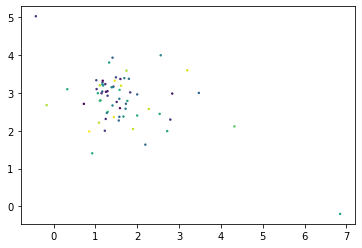

已记录区域 1


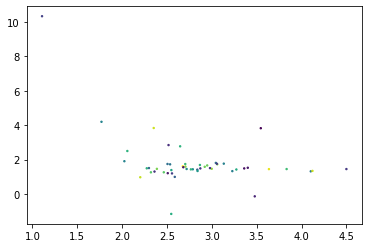

已记录区域 2


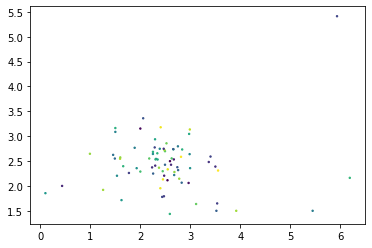

已记录区域 3


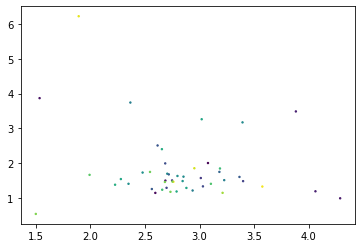

已记录区域 4


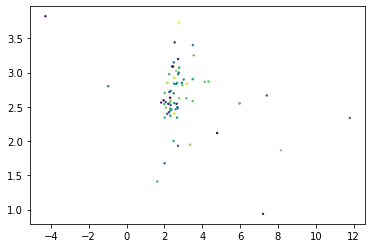

已记录区域 5


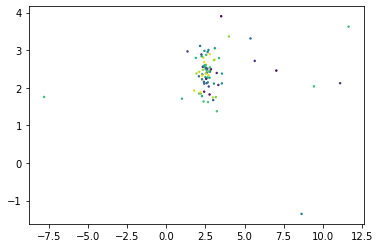

已记录区域 6


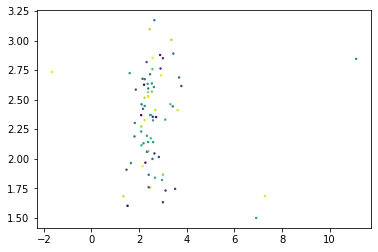

已记录区域 7


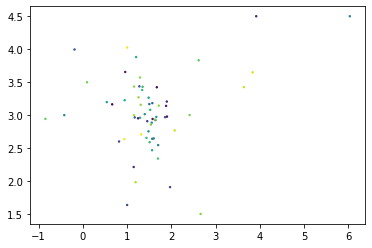

已记录区域 8


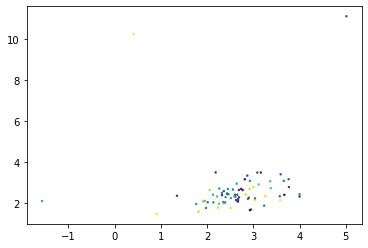

已记录区域 9


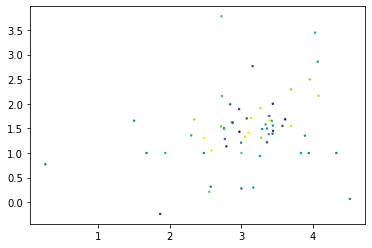

已记录区域 10


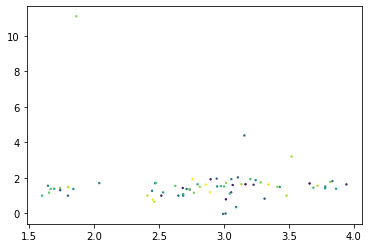

已记录区域 11


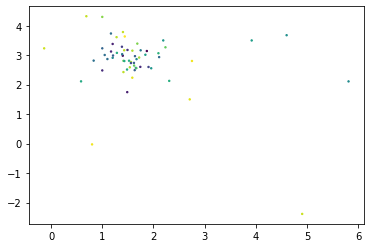

已记录区域 12


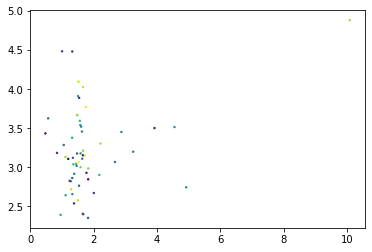

已记录区域 13


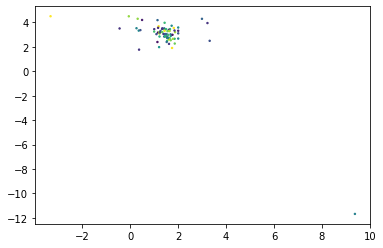

已记录区域 14


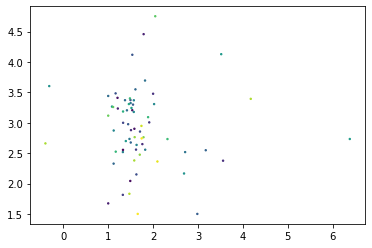

已记录区域 15


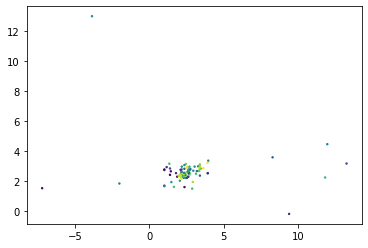

已记录区域 16


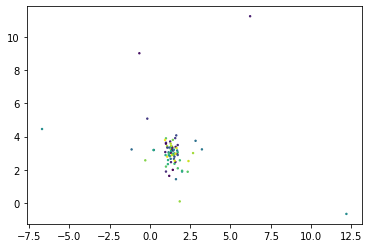

已记录区域 17


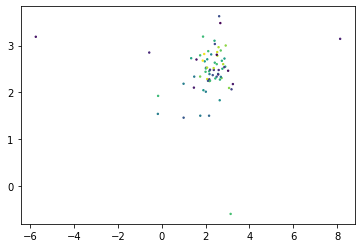

已记录区域 18


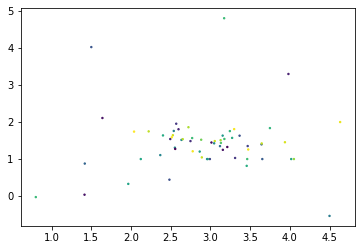

已记录区域 19


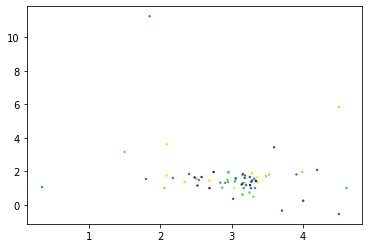

已记录区域 20


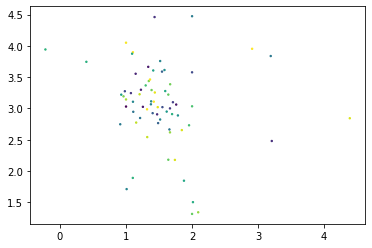

已记录区域 21


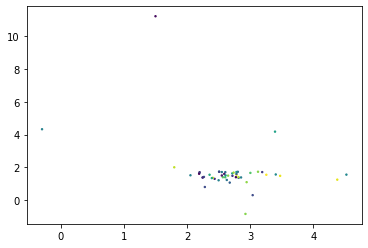

已记录区域 22


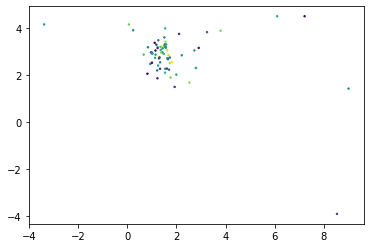

已记录区域 23


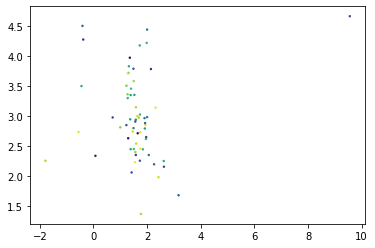

已记录区域 24


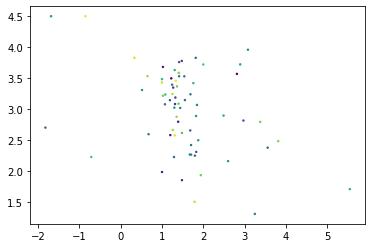

已记录区域 25


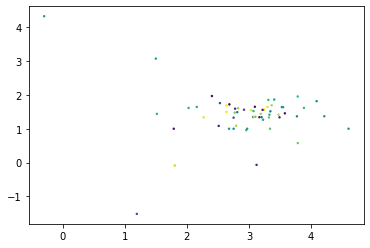

已记录区域 26


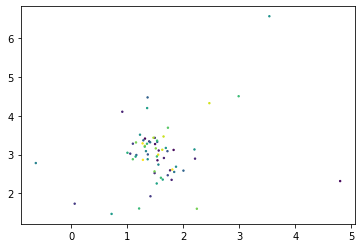

已记录区域 27


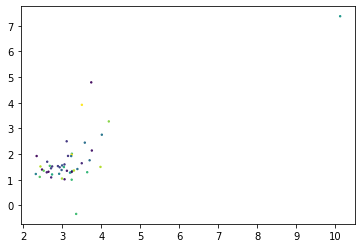

已记录区域 28


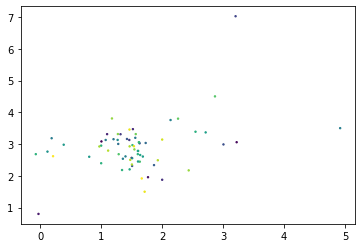

已记录区域 29


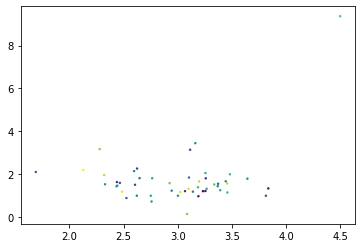

已记录区域 30


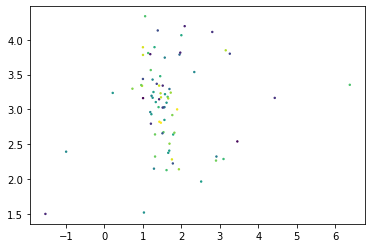

已记录区域 31


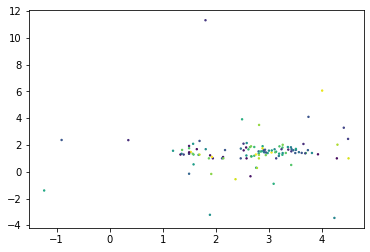

已记录区域 32


In [30]:
if __name__ == '__main__':

#     for eta in np.arange(1.6,3.2,0.01):
        eta = 2.24 #最优环境因子 eta = 2.24
        eta = round(eta,2) #保留2位
        test_y,test_x = Dataset("Test_1.csv")
        train_y,train_x = Dataset("Train_1.csv")
        vaploc = ApLoc("1",train_x,train_y,eta) #求每个区域虚拟AP的位置
        x_area,y_area = DivByArea(train_x,train_y) #按区域进行划分
        rss_1m = rss_1m_all(x_area,y_area,vaploc,eta) #求出所有标准距离的虚拟AP的信号强度
        


In [31]:
# eta 的选择
# #         output1 = open('./Data/vaploc_0_'+str(eta)+'.pkl', 'wb') #目标文件
# #         output2 = open('./Data/rss_1m_0_'+str(eta)+'.pkl', 'wb')
#         output1 = open('./Data/vaploc_1_'+str(eta)+'.pkl', 'wb') #目标文件
#         output2 = open('./Data/rss_1m_1_'+str(eta)+'.pkl', 'wb')
#         pickle.dump(vaploc, output1) #将虚拟AP的位置序列化到指定文件中
#         pickle.dump(rss_1m, output2) #将标准距离的虚拟AP强度序列化到指定文件中（ASCII）
        
        
# #         pkl_file1 = open('./Data/vaploc_0_'+str(eta)+'.pkl', 'rb')
# #         pkl_file2 = open('./Data/rss_1m_0_'+str(eta)+'.pkl', 'rb')
#         pkl_file1 = open('./Data/vaploc_1_'+str(eta)+'.pkl', 'rb')
#         pkl_file2 = open('./Data/rss_1m_1_'+str(eta)+'.pkl', 'rb')
# #         vaploc_ = pickle.load(pkl_file1) #反序列化，将文件中的数据解析为一个Pyhton对象
# #         rss_1m_ = pickle.load(pkl_file2)

        
#         dtrues = [] 
#         for i in range(len(test_x)):
#             sample_x = test_x[i]
#             sample_y = test_y[i]
#             area = sample_y[0]
#             print("样本",i,"of",len(test_x))
#             dtrue = evaluate(sample_x,sample_y,area,vaploc_,rss_1m_,eta)
#             dtrues.append(dtrue)

#         sum_d = np.sum(dtrues)

#         value = str(eta)+" "+str(sum_d)+ '\n'
#         with open('./Data/eta.txt','a') as f:
#             f.write(value)
            
# import matplotlib.pyplot as plt
# from scipy.signal import savgol_filter
# with  open("./Data/eta.txt","r") as f:
#     lines = f.readlines()
#     etas = []
#     losses = []
#     for line in lines:
#         line.strip('\n')
#         print(line.strip)
#         eta,loss = line.split(' ')
#         eta = float(eta)
#         loss = float(loss)
#         etas.append(eta)
#         losses.append(loss)
#     print(etas[losses.index(min(losses))])
#     filtered = savgol_filter(losses,17,3)
#     plt.title("Error affected by Eta") 
#     plt.xlabel("Eta") 
#     plt.ylabel("Sum of errors of all test samples") 
#     plt.plot(etas,losses,label="original")
#     plt.plot(etas,filtered,label="filtered")
#     plt.legend()
#     plt.savefig("./eta_select.png",dpi=120)
#     plt.show()

In [32]:
# # 绘制均方误差图
# #绘制MSE
       
# dtrues = [] 
# for i in range(len(test_x)):
#     sample_x = test_x[i]
#     sample_y = test_y[i]
#     area = sample_y[0]
#     print("样本",i,"of",len(test_x))
#     dtrue = evaluate(sample_x,sample_y,area,vaploc_,rss_1m_,eta)
#     dtrues.append(dtrue)
# sum_d = np.sum(dtrues)
# print(sum_d)